**Техническое задание:**

Для снижения издежек процесса производства сталей, "Стальная птица" выдвигает задачу:

Необходимо разработать модель, предсказывающую температуру сплава

**0. Подготовка**

In [3]:
RANDOM_STATE = 170724
N_TRIALS = 250

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np

from sklearn.datasets import make_regression
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sqlalchemy import create_engine
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

**1. Загрузка данных**

In [6]:
db_config = {
'user': 'praktikum_student',# имя пользователя
'pwd': 'Sdf4$2;d-d30pp',# пароль
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения
'db': 'data-science-final'# название базы данных,
}

In [7]:
connection_string  = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"

In [8]:
engine = create_engine(connection_string)

In [9]:
query_data_arc = "SELECT * FROM steel.data_arc;"
data_arc = pd.read_sql(query_data_arc, engine)

In [10]:
query_data_bulk = "SELECT * FROM steel.data_bulk;"
data_bulk = pd.read_sql(query_data_bulk, engine)

In [11]:
query_data_bulk_time = "SELECT * FROM steel.data_bulk_time;"
data_bulk_time = pd.read_sql(query_data_bulk_time, engine)

In [12]:
query_data_gas = "SELECT * FROM steel.data_gas;"
data_gas = pd.read_sql(query_data_gas, engine)

In [13]:
query_data_temp = "SELECT * FROM steel.data_temp;"
data_temp = pd.read_sql(query_data_temp, engine)

In [14]:
query_data_wire = "SELECT * FROM steel.data_wire;"
data_wire = pd.read_sql(query_data_wire, engine)

In [15]:
query_data_wire_time = "SELECT * FROM steel.data_wire_time;"
data_wire_time = pd.read_sql(query_data_wire_time, engine)

Выгружаю таблицы из СУБД

Все данные загружены

**2. Исследовательский анализ и предобработка данных**

In [19]:
def display_data(data):
    display(data.head(5))
    display(data.info())
    display(data.describe())

Функция вывода статистики на экран

In [21]:
def delete_outliers(data, target):

    Q1 = data[target].quantile(0.25)
    Q3 = data[target].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data = data[(data[target] >= lower_bound) & (data[target] <= upper_bound)]
    print('Удаляю выбросы')
    return data

Функция удаления выбросов

In [23]:
def create_stat_plots(data, target):
    if pd.api.types.is_numeric_dtype(data[target]):
    
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        sns.histplot(data[target], bins=30, kde=True, ax=ax1)
        ax1.set_title(f'Histogram of {target}')
    
        sns.boxplot(x=data[target], ax=ax2)
        ax2.set_title(f'Box Plot for {target}')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Столбец {target} имеет неверный тип данных")

Функция вывода графиков

In [25]:
def time_to_seconds(data):
    if pd.isnull(data):
        return None
    return data.hour * 3600 + data.minute * 60 + data.second

Функция пересчета времени в колчество секунд, прошкдших с начала дня

Загружено 7 таблиц. Часть данных в таблицах неопредеелна. Вероятно имеются аномалии

data_arc - данные об электродах. Пропусков нет.

In [29]:
data_arc.isnull().sum()

key              0
BeginHeat        0
EndHeat          0
ActivePower      0
ReactivePower    0
dtype: int64

In [30]:
display_data(data_arc)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [31]:
filtered_data_arc = data_arc.copy()

Копирую дату, чтобы проводить манипуляции

Столбцы BeginHeat и EndHeat являются временем. Перевод к типу datetime не даст полезных признаков, поэтому переведу к значению - количество секунд, прошедшее с начала дня 

In [34]:
filtered_data_arc['BeginHeat'] = filtered_data_arc['BeginHeat'].apply(time_to_seconds)
filtered_data_arc['EndHeat'] = filtered_data_arc['EndHeat'].apply(time_to_seconds)

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


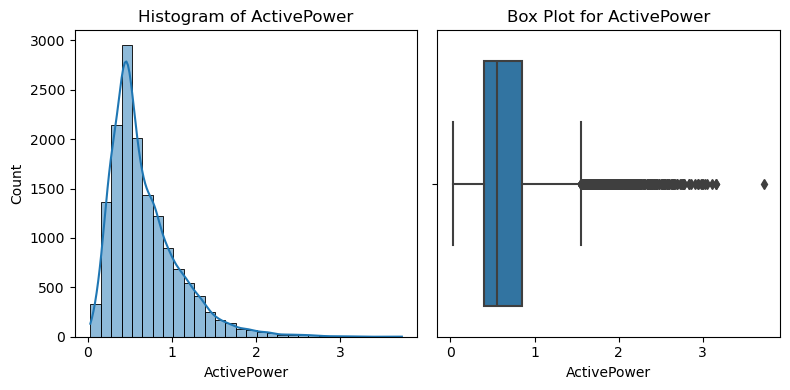

In [35]:
create_stat_plots(filtered_data_arc, 'ActivePower')

In [36]:
filtered_data_arc = delete_outliers(filtered_data_arc, 'ActivePower')

Удаляю выбросы


D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


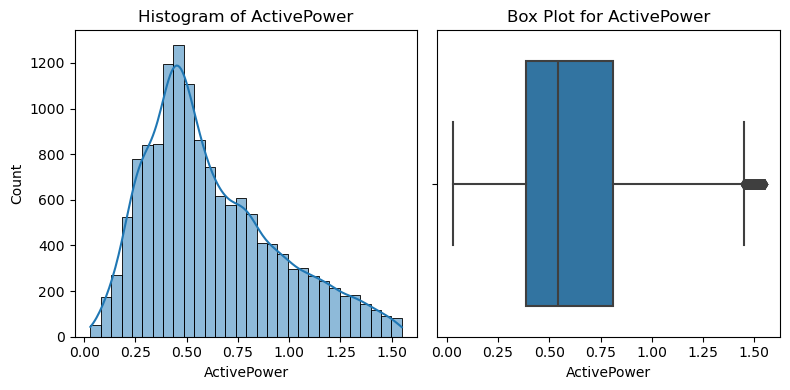

In [37]:
create_stat_plots(filtered_data_arc, 'ActivePower')

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


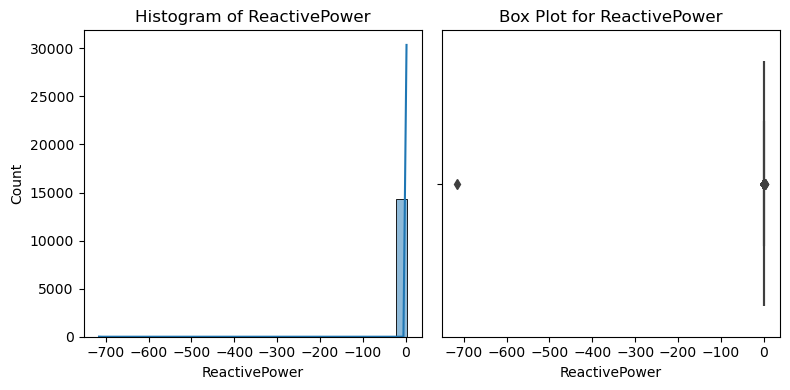

In [38]:
create_stat_plots(filtered_data_arc, 'ReactivePower')

In [39]:
filtered_data_arc = delete_outliers(filtered_data_arc, 'ReactivePower')

Удаляю выбросы


D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


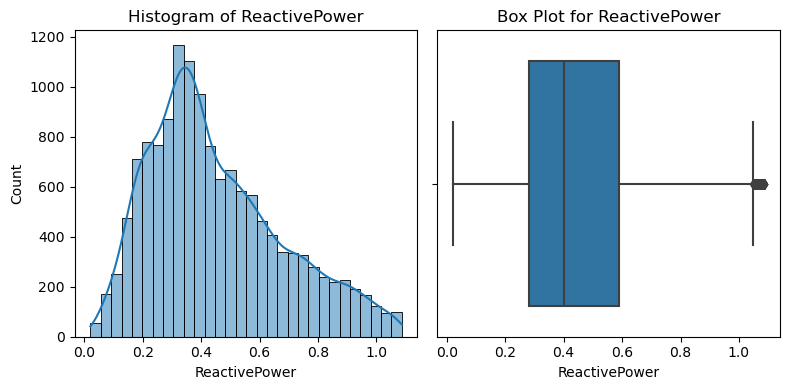

In [40]:
create_stat_plots(filtered_data_arc, 'ReactivePower')

Дата выглядит адекватно

In [42]:
display_data(filtered_data_arc)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,39734,39962,0.976059,0.687084
1,1,40048,40233,0.805607,0.520285
2,1,40304,40476,0.744363,0.498805
4,1,41169,41317,0.692755,0.414397
5,2,41654,41791,0.438063,0.283043


<class 'pandas.core.frame.DataFrame'>
Index: 14055 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14055 non-null  int64  
 1   BeginHeat      14055 non-null  int64  
 2   EndHeat        14055 non-null  int64  
 3   ActivePower    14055 non-null  float64
 4   ReactivePower  14055 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 658.8 KB


None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
count,14055.000000,14055.000000,14055.000000,14055.000000,14055.000000
mean,1614.544504,43212.008324,43245.599929,0.607793,0.450558
std,934.140974,25004.085825,25003.091224,0.308293,0.228647
min,1.000000,1.000000,7.000000,0.030002,0.020806
25%,808.000000,21848.000000,21831.500000,0.385834,0.282589
50%,1609.000000,42897.000000,42951.000000,0.534532,0.399423
75%,2431.000000,64871.000000,64831.000000,0.796844,0.589382
max,3241.000000,86375.000000,86398.000000,1.549535,1.087188


In [43]:
removed_count_data_arc = data_arc.shape[0] - filtered_data_arc.shape[0]
percentage_removed_data_arc = (removed_count_data_arc / data_arc.shape[0]) * 100

print(f'Удалено {removed_count_data_arc} строк')
print(f'{percentage_removed_data_arc:.2f}% от первоначальных данных')

Удалено 821 строк
5.52% от первоначальных данных


Извлеку новые данные из признаков:

Общее время нагрева:

In [46]:
filtered_data_arc['WorkingTime'] = (filtered_data_arc['EndHeat'] - filtered_data_arc['BeginHeat'])

Общая мощность

In [48]:
filtered_data_arc['GeneralPower'] = filtered_data_arc['ActivePower'] + filtered_data_arc['ReactivePower']

Средняя мощность

In [50]:
filtered_data_arc['AveragePower'] = (filtered_data_arc['ActivePower'] + filtered_data_arc['ReactivePower']) / 2

Отношение активной мощности к реактивной

In [52]:
filtered_data_arc['PowerRatio'] = filtered_data_arc['ActivePower'] / filtered_data_arc['ReactivePower']

In [53]:
aggregated_data_arc = filtered_data_arc.groupby('key').agg({
    'BeginHeat': 'min',
    'EndHeat': 'max',
    'ActivePower': 'mean',
    'ReactivePower': 'mean',
    'WorkingTime': 'sum',
    'GeneralPower': 'sum',
    'PowerRatio' : 'mean',
    'AveragePower': 'mean'
}).reset_index()

Агрегирую данные

In [55]:
display_data(aggregated_data_arc)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,WorkingTime,GeneralPower,PowerRatio,AveragePower
0,1,39734,41317,0.804696,0.530143,733,5.339356,1.533246,0.667419
1,2,41654,42798,0.763150,0.499528,811,5.050710,1.551834,0.631339
2,3,43614,45139,0.505176,0.319815,655,4.124958,1.583120,0.412496
3,4,45577,46670,0.802313,0.515074,741,5.269548,1.563487,0.658693
4,5,47473,48835,0.575169,0.401622,454,2.930375,1.457997,0.488396


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            3214 non-null   int64  
 1   BeginHeat      3214 non-null   int64  
 2   EndHeat        3214 non-null   int64  
 3   ActivePower    3214 non-null   float64
 4   ReactivePower  3214 non-null   float64
 5   WorkingTime    3214 non-null   int64  
 6   GeneralPower   3214 non-null   float64
 7   PowerRatio     3214 non-null   float64
 8   AveragePower   3214 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 226.1 KB


None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,WorkingTime,GeneralPower,PowerRatio,AveragePower
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1623.061294,41017.474487,44295.262290,0.611845,0.454367,146.897946,4.628227,1.361365,0.533106
std,934.739859,24889.869724,24949.821006,0.161435,0.118506,6790.346192,1.917127,0.132692,0.136955
min,1.000000,1.000000,733.000000,0.172290,0.130062,-86053.000000,0.304210,0.676106,0.152105
25%,817.250000,19598.500000,22962.500000,0.495583,0.369871,491.000000,3.272207,1.295935,0.435747
50%,1623.500000,40282.500000,43714.000000,0.599969,0.446313,662.000000,4.507133,1.373128,0.524623
75%,2431.750000,62297.250000,65722.750000,0.717887,0.531665,843.000000,5.803603,1.441920,0.624814
max,3241.000000,85634.000000,86398.000000,1.261694,0.986905,2220.000000,15.775569,1.785275,1.114584


data_bulk - данные об объёме сыпучих материалов;

In [57]:
display_data(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [58]:
filtered_data_bulk = data_bulk.copy()

Создам признак - список вводимых элементов

In [60]:
filtered_data_bulk['Bulk Array'] = filtered_data_bulk.apply(lambda row: ', '.join(row.index[(row.notna()) & (row.index != 'key')]), axis=1)

Предполагаю, что NaN в контексте данной таблицы означает, что в смесь не вводились конкретные элементы, а значит, значение NaN можно интерпретировать как 0.

In [62]:
filtered_data_bulk.fillna(0, inplace=True)

Создам признак - общий объем вводимых смесей

In [64]:
filtered_data_bulk['Bulk Amount'] = filtered_data_bulk.drop(columns=['key', 'Bulk Array']).sum(axis=1)

In [65]:
display_data(filtered_data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk Array,Bulk Amount
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",553.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",582.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",544.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",595.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",584.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3129 non-null   int64  
 1   Bulk 1       3129 non-null   float64
 2   Bulk 2       3129 non-null   float64
 3   Bulk 3       3129 non-null   float64
 4   Bulk 4       3129 non-null   float64
 5   Bulk 5       3129 non-null   float64
 6   Bulk 6       3129 non-null   float64
 7   Bulk 7       3129 non-null   float64
 8   Bulk 8       3129 non-null   float64
 9   Bulk 9       3129 non-null   float64
 10  Bulk 10      3129 non-null   float64
 11  Bulk 11      3129 non-null   float64
 12  Bulk 12      3129 non-null   float64
 13  Bulk 13      3129 non-null   float64
 14  Bulk 14      3129 non-null   float64
 15  Bulk 15      3129 non-null   float64
 16  Bulk Array   3129 non-null   object 
 17  Bulk Amount  3129 non-null   float64
dtypes: float64(16), int64(1), object(1)
memory usage

None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk Amount
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271,595.503356
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698,276.557794
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000,429.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000,591.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000,772.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,3235.000000


data_bulk_time - данные о времени подачи сыпучих материалов;

In [67]:
display_data(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [68]:
filtered_data_bulk_time = data_bulk_time.copy()

Создам признак - список вводимых элементов

In [70]:
filtered_data_bulk_time['Array Time'] = filtered_data_bulk_time.apply(lambda row: ', '.join(row.index[(row.notna()) & (row.index != 'key')]), axis=1)

In [71]:
time_columns = [col for col in filtered_data_bulk_time.columns if 'Bulk' in col]

for col in time_columns:
    filtered_data_bulk_time[col] = filtered_data_bulk_time[col].apply(time_to_seconds)

NaT заменю по тому же принципу как для filtered_data_bulk

In [73]:
filtered_data_bulk_time.fillna(0, inplace=True)

In [74]:
filtered_data_bulk_time['Bulk Time Amount'] = filtered_data_bulk_time.drop(columns=['key', 'Array Time']).sum(axis=1)

In [75]:
filtered_data_bulk_time = filtered_data_bulk_time.rename(columns={'Array Time': 'Bulk Time Array'})

In [76]:
display_data(filtered_data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk Time Array,Bulk Time Amount
0,1,0.0,0.0,0.0,40890.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39832.0,0.0,39832.0,39832.0,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",160386.0
1,2,0.0,0.0,0.0,42398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42020.0,0.0,42020.0,42020.0,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",168458.0
2,3,0.0,0.0,0.0,45066.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43780.0,0.0,43780.0,43780.0,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",176406.0
3,4,0.0,0.0,0.0,46123.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45684.0,0.0,45684.0,45684.0,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",183175.0
4,5,0.0,0.0,0.0,47930.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47576.0,0.0,47576.0,47576.0,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",190658.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3129 non-null   int64  
 1   Bulk 1            3129 non-null   float64
 2   Bulk 2            3129 non-null   float64
 3   Bulk 3            3129 non-null   float64
 4   Bulk 4            3129 non-null   float64
 5   Bulk 5            3129 non-null   float64
 6   Bulk 6            3129 non-null   float64
 7   Bulk 7            3129 non-null   float64
 8   Bulk 8            3129 non-null   float64
 9   Bulk 9            3129 non-null   float64
 10  Bulk 10           3129 non-null   float64
 11  Bulk 11           3129 non-null   float64
 12  Bulk 12           3129 non-null   float64
 13  Bulk 13           3129 non-null   float64
 14  Bulk 14           3129 non-null   float64
 15  Bulk 15           3129 non-null   float64
 16  Bulk Time Array   3129 non-null   object 


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk Time Amount
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3691.147331,328.750399,18231.661873,13273.860339,1014.913391,8090.508789,318.832215,20.444551,185.247683,2293.313519,2540.970598,33128.979546,289.971556,38224.277085,30184.867050,151817.745925
std,933.337642,14075.550826,4021.115985,26910.203596,23760.492792,7622.819033,20206.533772,3762.291564,1143.616356,2991.874639,10894.893018,11846.135438,28258.348972,4311.547475,27059.870939,28511.810068,106485.794097
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3393.000000,0.000000,13737.000000,0.000000,59365.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29643.000000,0.000000,36546.000000,24372.000000,134498.000000
75%,2431.000000,0.000000,0.000000,34707.000000,17769.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58471.000000,0.000000,61730.000000,55093.000000,234347.000000
max,3241.000000,86064.000000,64910.000000,86252.000000,86370.000000,85354.000000,86175.000000,64910.000000,63971.000000,68281.000000,84770.000000,86175.000000,86334.000000,84845.000000,86334.000000,86334.000000,493075.000000


data_gas - данные о продувке сплава газом;

In [78]:
display_data(data_gas)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [79]:
filtered_data_gas = data_gas.copy()

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


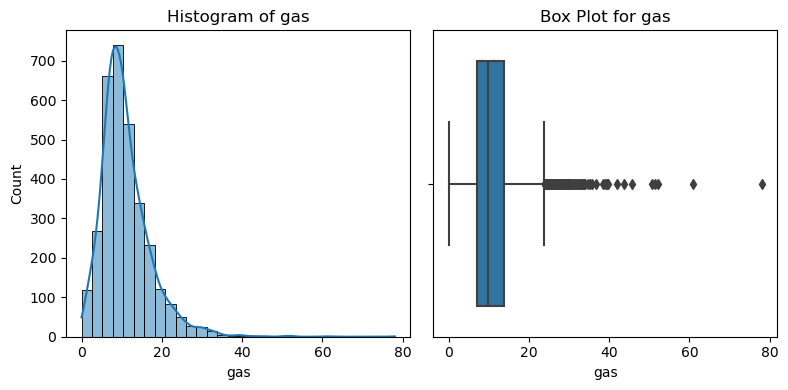

In [80]:
create_stat_plots(filtered_data_gas, 'gas')

In [81]:
filtered_data_gas = delete_outliers(filtered_data_gas, 'gas')

Удаляю выбросы


D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


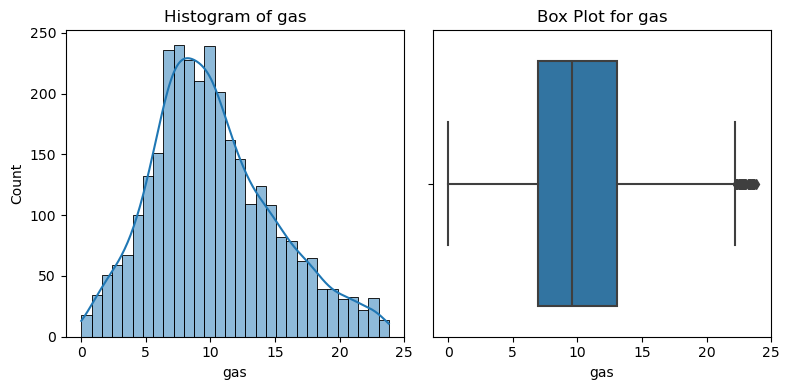

In [82]:
create_stat_plots(filtered_data_gas, 'gas')

data_temp - данные об измерениях температуры;

In [84]:
display_data(data_temp)

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [85]:
filtered_data_temp = data_temp.copy()

In [86]:
filtered_data_temp = filtered_data_temp.dropna()

In [87]:
filtered_data_temp = filtered_data_temp[filtered_data_temp['Temperature'] >= 1500]

In [88]:
removed_count_data_temp = data_temp.shape[0] - filtered_data_temp.shape[0]
percentage_removed_data_temp = (removed_count_data_temp / data_temp.shape[0]) * 100

print(f'Удалено {removed_count_data_temp} строк')
print(f'{percentage_removed_data_temp:.2f}% от первоначальных данных')

Удалено 2908 строк
18.28% от первоначальных данных


Довольно много строк удалено

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


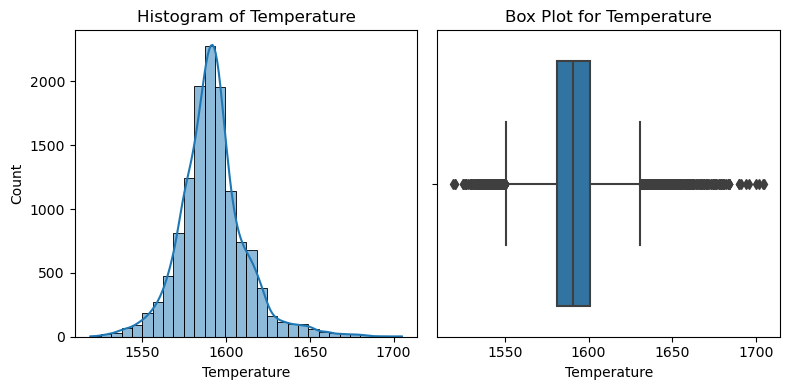

In [90]:
create_stat_plots(filtered_data_temp, 'Temperature')

In [91]:
filtered_data_temp = delete_outliers(filtered_data_temp, 'Temperature')

Удаляю выбросы


D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


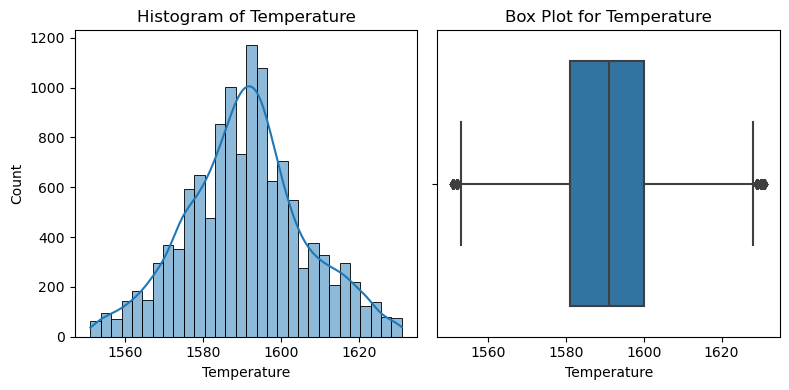

In [92]:
create_stat_plots(filtered_data_temp, 'Temperature')

In [93]:
filtered_data_temp['MesaureTime'] = pd.to_datetime(filtered_data_temp['MesaureTime'], format='%H:%M:%S').dt.time

In [94]:
filtered_data_temp['row_count'] = filtered_data_temp.groupby('key')['key'].transform('count')

In [95]:
group = filtered_data_temp.groupby('key')
filtered_groups = group.filter(lambda x: len(x) >= 2)

In [96]:
aggregated_data_temp = filtered_groups.groupby('key').agg(
    first_measure_time=('MesaureTime', 'first'),
    first_temperature=('Temperature', 'first'),
    last_measure_time=('MesaureTime', 'last'),
    last_temperature=('Temperature', 'last'),
    row_count=('row_count', 'max')
).reset_index()

In [97]:
aggregated_data_temp['first_measure_time_hour'] = aggregated_data_temp['first_measure_time'].apply(
    lambda x: x.hour if pd.notnull(x) else None
)

In [98]:
aggregated_data_temp['first_measure_time_minute'] = aggregated_data_temp['first_measure_time'].apply(
    lambda x: x.minute if pd.notnull(x) else None
)

In [99]:
aggregated_data_temp['first_measure_time_second'] = aggregated_data_temp['first_measure_time'].apply(
    lambda x: x.second if pd.notnull(x) else None
)

In [100]:
aggregated_data_temp['first_measure_time'] = aggregated_data_temp['first_measure_time'].apply(time_to_seconds)

In [101]:
aggregated_data_temp['last_measure_time'] = aggregated_data_temp['last_measure_time'].apply(time_to_seconds)

In [102]:
display_data(aggregated_data_temp)

,key,first_measure_time,first_temperature,last_measure_time,last_temperature,row_count,first_measure_time_hour,first_measure_time_minute,first_measure_time_second
0,1,40578,1571.0,41439,1613.0,5,11,16,18
1,2,41847,1581.0,43152,1602.0,6,11,37,27
2,3,43997,1596.0,45297,1599.0,5,12,13,17
3,4,46377,1601.0,46765,1625.0,3,12,52,57
4,5,48199,1576.0,48961,1602.0,2,13,23,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405 entries, 0 to 2404
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        2405 non-null   int64  
 1   first_measure_time         2405 non-null   int64  
 2   first_temperature          2405 non-null   float64
 3   last_measure_time          2405 non-null   int64  
 4   last_temperature           2405 non-null   float64
 5   row_count                  2405 non-null   int64  
 6   first_measure_time_hour    2405 non-null   int64  
 7   first_measure_time_minute  2405 non-null   int64  
 8   first_measure_time_second  2405 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 169.2 KB


None

,key,first_measure_time,first_temperature,last_measure_time,last_temperature,row_count,first_measure_time_hour,first_measure_time_minute,first_measure_time_second
count,2405.000000,2405.000000,2405.000000,2405.000000,2405.000000,2405.000000,2405.000000,2405.000000,2405.000000
mean,1252.010811,42591.648233,1587.912266,42526.089813,1593.423285,4.822453,11.333056,29.386279,29.469439
std,718.619119,24924.653743,19.785670,24944.591189,11.146153,1.764315,6.919318,17.167378,17.156263
min,1.000000,68.000000,1551.000000,54.000000,1551.000000,2.000000,0.000000,0.000000,0.000000
25%,628.000000,21033.000000,1572.000000,21100.000000,1587.000000,4.000000,5.000000,15.000000,15.000000
50%,1254.000000,42184.000000,1587.000000,42064.000000,1593.000000,5.000000,11.000000,29.000000,29.000000
75%,1876.000000,63874.000000,1603.000000,63717.000000,1598.000000,6.000000,17.000000,44.000000,44.000000
max,2499.000000,86379.000000,1631.000000,86394.000000,1631.000000,16.000000,23.000000,59.000000,59.000000


data_wire - данные об объёме проволочных материалов;

In [104]:
display_data(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [105]:
filtered_data_wire = data_wire.copy()

In [106]:
filtered_data_wire['Wire Array'] = filtered_data_wire.apply(lambda row: ', '.join(row.index[(row.notna()) & (row.index != 'key')]), axis=1)

In [107]:
filtered_data_wire.fillna(0, inplace=True)

In [108]:
filtered_data_wire['Wire Amount'] = filtered_data_wire.drop(columns=['key', 'Wire Array']).sum(axis=1)

In [109]:
display_data(filtered_data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire Array,Wire Amount
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wire 1,60.059998
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wire 1,96.052315
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wire 1,91.160157
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wire 1,89.063515
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Wire 1, Wire 2",98.352796


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3081 non-null   int64  
 1   Wire 1       3081 non-null   float64
 2   Wire 2       3081 non-null   float64
 3   Wire 3       3081 non-null   float64
 4   Wire 4       3081 non-null   float64
 5   Wire 5       3081 non-null   float64
 6   Wire 6       3081 non-null   float64
 7   Wire 7       3081 non-null   float64
 8   Wire 8       3081 non-null   float64
 9   Wire 9       3081 non-null   float64
 10  Wire Array   3081 non-null   object 
 11  Wire Amount  3081 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 289.0+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire Amount
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492,123.723326
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904,66.082966
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.918800
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.112000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,114.179523
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.181198
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604,663.851766


data_wire_time - данные о времени подачи проволочных материалов

In [111]:
display_data(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [112]:
filtered_data_wire_time = data_wire_time.copy()

In [113]:
filtered_data_wire_time['Array Time'] = filtered_data_wire_time.apply(lambda row: ', '.join(row.index[(row.notna()) & (row.index != 'key')]), axis=1)

In [114]:
time_columns = [col for col in filtered_data_wire_time.columns if 'Wire' in col]

for col in time_columns:
    filtered_data_wire_time[col] = filtered_data_wire_time[col].apply(time_to_seconds)

In [115]:
filtered_data_wire_time.fillna(0, inplace=True)

In [116]:
filtered_data_wire_time['Wire Time Amount'] = filtered_data_wire_time.drop(columns=['key', 'Array Time']).sum(axis=1)

In [117]:
filtered_data_wire_time = filtered_data_wire_time.rename(columns={'Array Time': 'Wire Time Array'})

In [118]:
display_data(filtered_data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire Time Array,Wire Time Amount
0,1,40301.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wire 1,40301.0
1,2,42370.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wire 1,42370.0
2,3,44027.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wire 1,44027.0
3,4,46085.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wire 1,46085.0
4,5,47895.0,48726.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Wire 1, Wire 2",96621.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3081 non-null   int64  
 1   Wire 1            3081 non-null   float64
 2   Wire 2            3081 non-null   float64
 3   Wire 3            3081 non-null   float64
 4   Wire 4            3081 non-null   float64
 5   Wire 5            3081 non-null   float64
 6   Wire 6            3081 non-null   float64
 7   Wire 7            3081 non-null   float64
 8   Wire 8            3081 non-null   float64
 9   Wire 9            3081 non-null   float64
 10  Wire Time Array   3081 non-null   object 
 11  Wire Time Amount  3081 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 289.0+ KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Wire Time Amount
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,42374.519636,15139.939630,1012.818241,193.507303,18.716975,1148.183707,183.107433,187.731256,418.026939,60676.551120
std,932.996726,25271.387379,25394.929061,7645.937048,2962.065321,1038.918571,8185.491403,3147.588129,3010.671232,5094.807661,45978.396397
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000
25%,823.000000,20526.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25659.000000
50%,1619.000000,41753.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52428.000000
75%,2434.000000,64351.000000,24115.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,81355.000000
max,3241.000000,86395.000000,86334.000000,84466.000000,65372.000000,57667.000000,85660.000000,71176.000000,68287.000000,86356.000000,334293.000000


In [119]:
main_data = pd.merge(aggregated_data_arc, filtered_data_bulk, on='key', how='inner')
main_data = pd.merge(main_data, filtered_data_bulk_time, on='key', how='inner', suffixes=('', ' Bulk'))
main_data = pd.merge(main_data, filtered_data_gas, on='key', how='inner')
main_data = pd.merge(main_data, aggregated_data_temp, on='key', how='inner')
main_data = pd.merge(main_data, filtered_data_wire, on='key', how='inner')
main_data = pd.merge(main_data, filtered_data_wire_time, on='key', how='inner', suffixes=('', ' Wire'))

selected_columns = list(aggregated_data_arc.columns) + ['Bulk Array', 'Bulk Amount', 'Bulk Time Array', 'Bulk Time Amount','Wire Array', 'Wire Amount', 'Wire Time Array', 'Wire Time Amount'] \
                     + list(filtered_data_gas.columns[1:]) + list(aggregated_data_temp.columns[1:])
main_data = main_data[selected_columns]

In [120]:
display_data(main_data)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,WorkingTime,GeneralPower,PowerRatio,AveragePower,Bulk Array,...,Wire Time Amount,gas,first_measure_time,first_temperature,last_measure_time,last_temperature,row_count,first_measure_time_hour,first_measure_time_minute,first_measure_time_second
0,2,41654,42798,0.763150,0.499528,811,5.050710,1.551834,0.631339,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",...,42370.0,12.555561,41847,1581.0,43152,1602.0,6,11,37,27
1,4,45577,46670,0.802313,0.515074,741,5.269548,1.563487,0.658693,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",...,46085.0,18.841219,46377,1601.0,46765,1625.0,3,12,52,57
2,5,47473,48835,0.575169,0.401622,454,2.930375,1.457997,0.488396,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",...,96621.0,5.413692,48199,1576.0,48961,1602.0,2,13,23,19
3,6,49611,50964,0.767345,0.484151,554,3.754489,1.556920,0.625748,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",...,100736.0,11.273392,50671,1581.0,51149,1596.0,4,14,4,31
4,7,51406,52875,0.636844,0.390324,673,4.108670,1.628748,0.513584,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",...,52126.0,9.836267,51583,1586.0,52957,1599.0,5,14,19,43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2220 entries, 0 to 2219
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        2220 non-null   int64  
 1   BeginHeat                  2220 non-null   int64  
 2   EndHeat                    2220 non-null   int64  
 3   ActivePower                2220 non-null   float64
 4   ReactivePower              2220 non-null   float64
 5   WorkingTime                2220 non-null   int64  
 6   GeneralPower               2220 non-null   float64
 7   PowerRatio                 2220 non-null   float64
 8   AveragePower               2220 non-null   float64
 9   Bulk Array                 2220 non-null   object 
 10  Bulk Amount                2220 non-null   float64
 11  Bulk Time Array            2220 non-null   object 
 12  Bulk Time Amount           2220 non-null   float64
 13  Wire Array                 2220 non-null   objec

None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,WorkingTime,GeneralPower,PowerRatio,AveragePower,Bulk Amount,...,Wire Time Amount,gas,first_measure_time,first_temperature,last_measure_time,last_temperature,row_count,first_measure_time_hour,first_measure_time_minute,first_measure_time_second
count,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,...,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000
mean,1252.740090,40730.743694,44066.682432,0.614254,0.455662,185.729730,4.675405,1.364405,0.534958,600.121171,...,59510.205856,10.481987,42456.798198,1587.440541,42374.181532,1593.236036,4.786486,11.294144,29.472523,29.527928
std,711.911645,24860.042199,24940.241848,0.159975,0.118796,6593.728639,1.867921,0.130203,0.136375,279.184488,...,44786.321712,4.707841,24915.083227,19.638476,24910.612440,10.723119,1.712662,6.915407,17.232542,17.178480
min,2.000000,2.000000,733.000000,0.186226,0.130062,-86029.000000,0.361557,0.687735,0.158950,19.000000,...,51.000000,0.008399,68.000000,1551.000000,54.000000,1554.000000,2.000000,0.000000,0.000000,0.000000
25%,635.750000,19093.250000,22380.750000,0.498352,0.371061,502.000000,3.346740,1.296893,0.437581,431.750000,...,25323.000000,7.138971,20846.750000,1572.000000,20752.500000,1587.000000,4.000000,5.000000,15.000000,15.000000
50%,1256.500000,40032.000000,43561.500000,0.601829,0.445964,678.000000,4.579658,1.376016,0.524654,604.000000,...,51841.000000,9.886518,41848.000000,1586.500000,41850.000000,1593.000000,5.000000,11.000000,29.000000,29.000000
75%,1864.250000,61579.500000,65361.500000,0.721421,0.535424,857.000000,5.845567,1.443177,0.626170,783.250000,...,80488.750000,13.498771,63755.250000,1602.000000,63454.000000,1598.000000,6.000000,17.000000,45.000000,44.000000
max,2499.000000,85634.000000,86398.000000,1.261694,0.986905,2196.000000,15.373229,1.785275,1.114584,1569.000000,...,258768.000000,23.811279,86379.000000,1631.000000,86394.000000,1631.000000,16.000000,23.000000,59.000000,59.000000


In [121]:
main_data.loc[main_data['Bulk Time Array'] != main_data['Bulk Array'], ['Bulk Time Array', 'Bulk Array']]

,Bulk Time Array,Bulk Array


Расхождений нет, один из столбцов можно удалить

In [123]:
main_data = main_data.drop('Bulk Time Array', axis=1)

In [124]:
main_data.loc[main_data['Wire Time Array'] != main_data['Wire Array'], ['Wire Time Array', 'Wire Array']]

,Wire Time Array,Wire Array


Расхождений нет, один из столбцов можно удалить

In [126]:
main_data = main_data.drop('Wire Time Array', axis=1)

In [127]:
main_data[main_data['WorkingTime'] < 0][ 'WorkingTime'].count()

13

In [128]:
main_data = main_data[main_data['WorkingTime'] >= 0]

Рабочее время нагрева ушло в минус. Удалю эти строки.

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


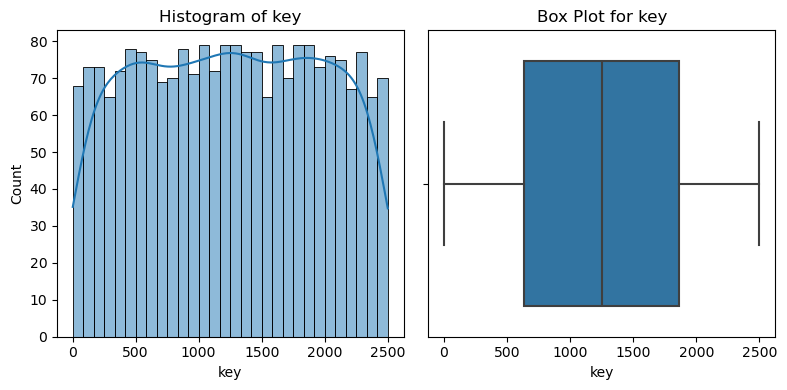

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


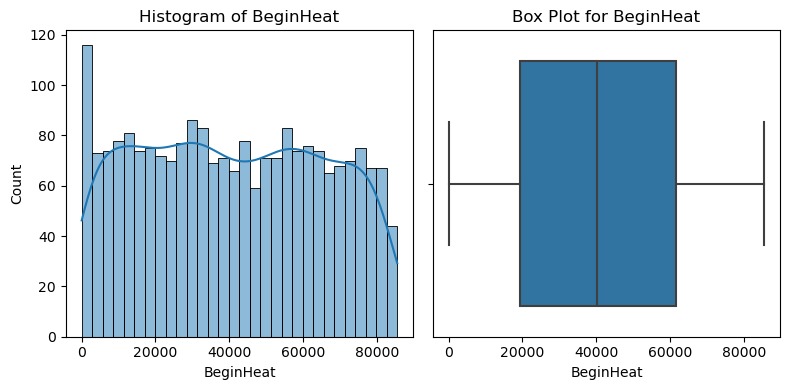

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


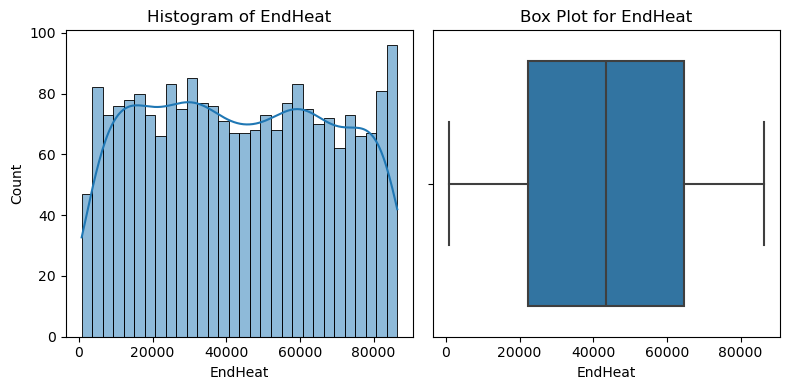

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


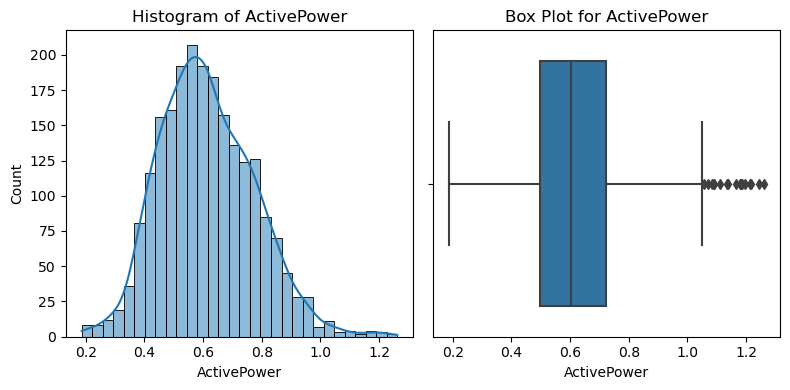

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


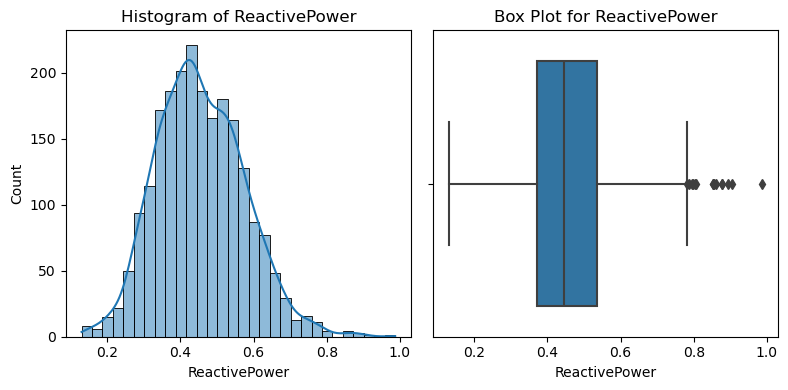

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


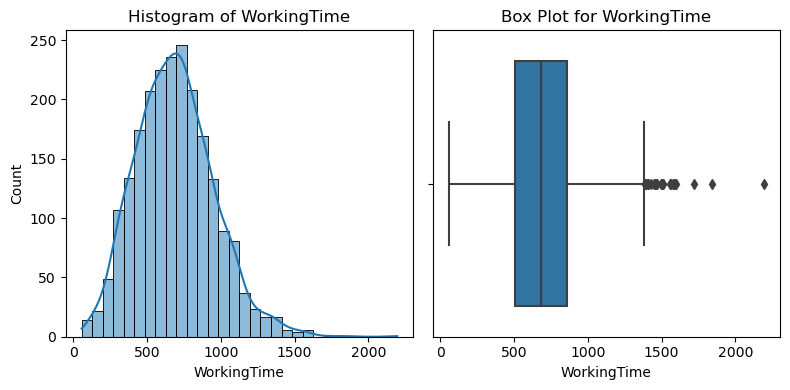

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


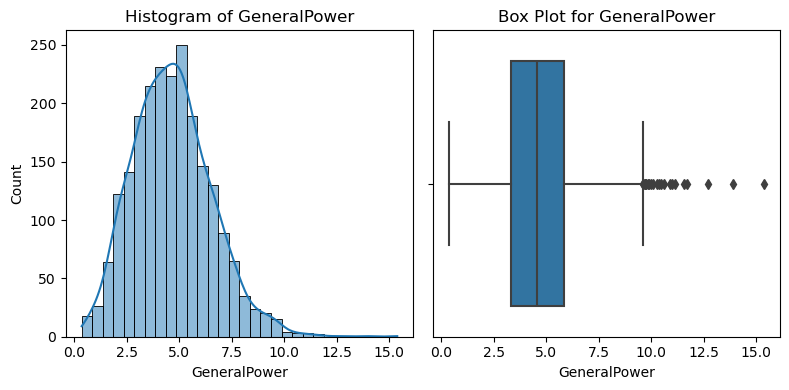

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


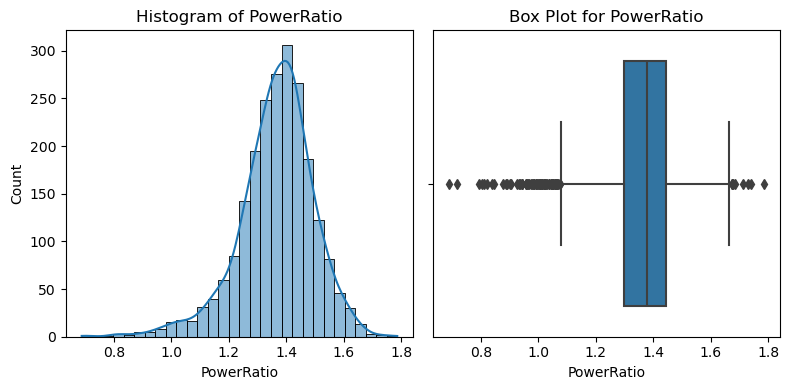

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


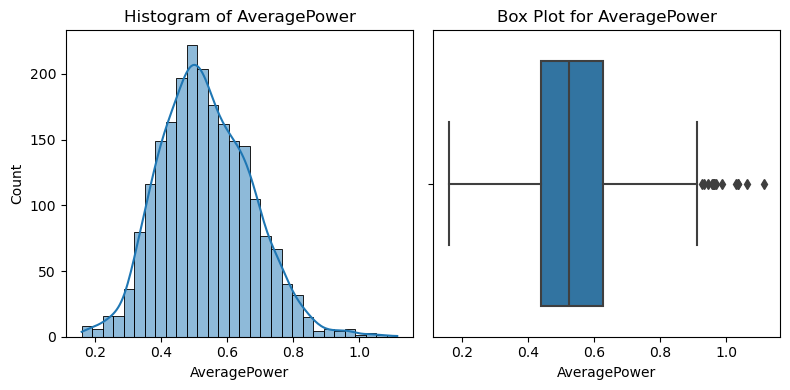

Столбец Bulk Array имеет неверный тип данных


D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


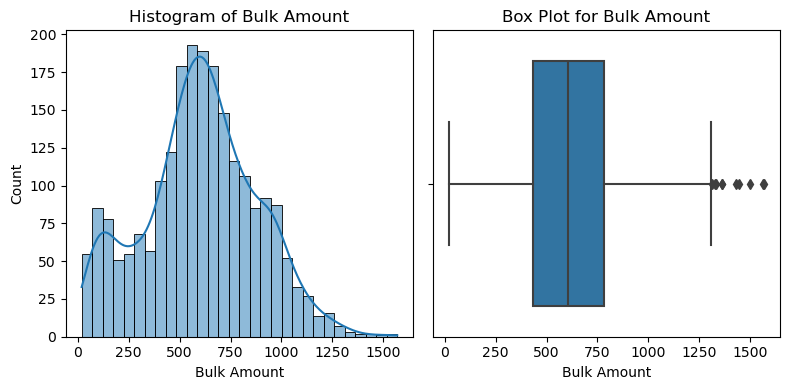

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


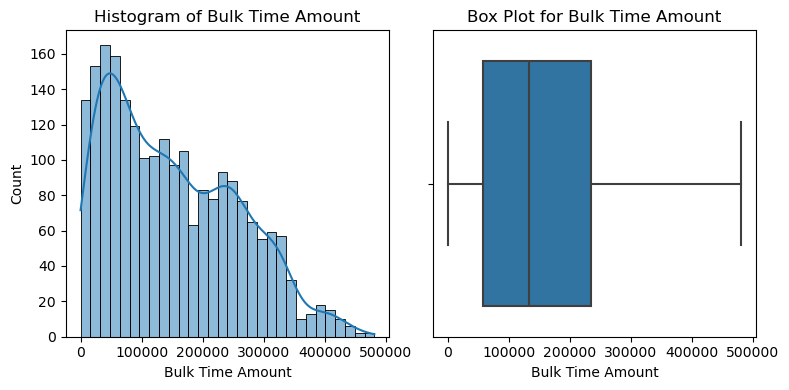

Столбец Wire Array имеет неверный тип данных


D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


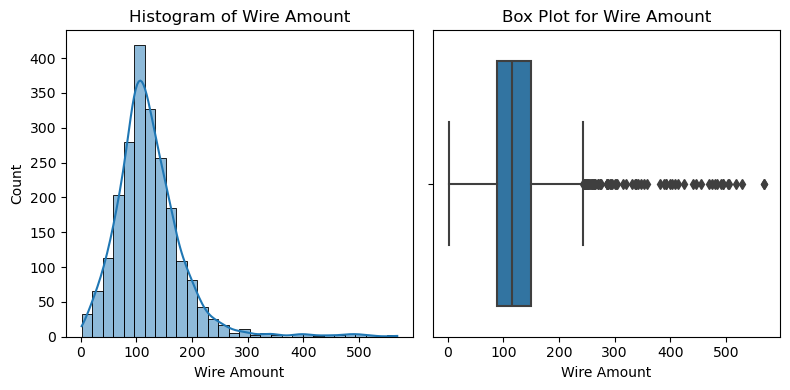

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


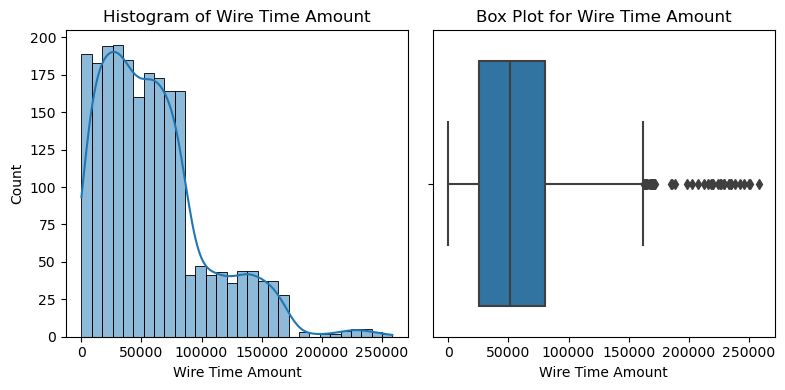

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


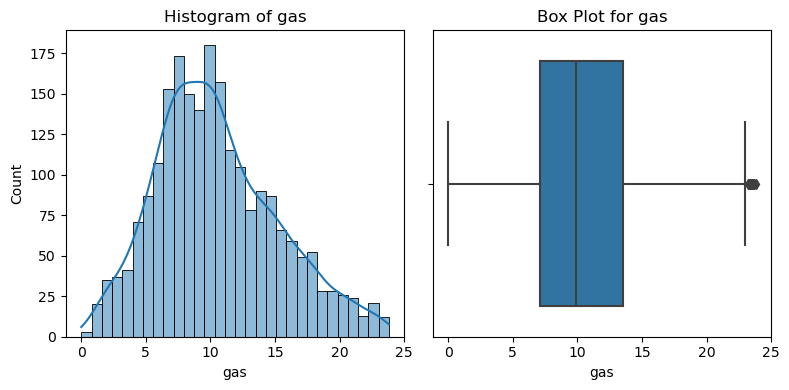

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


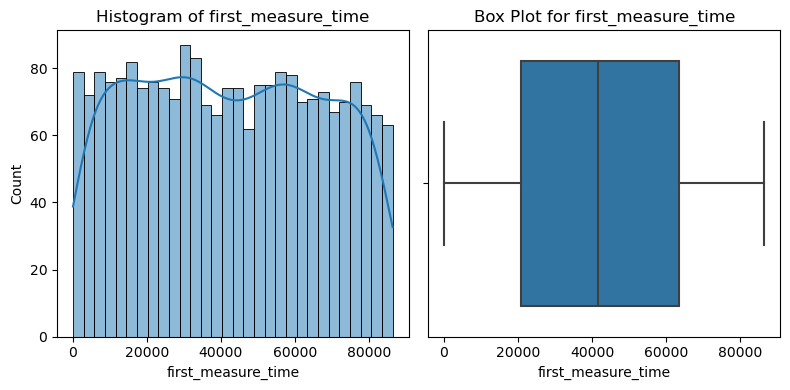

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


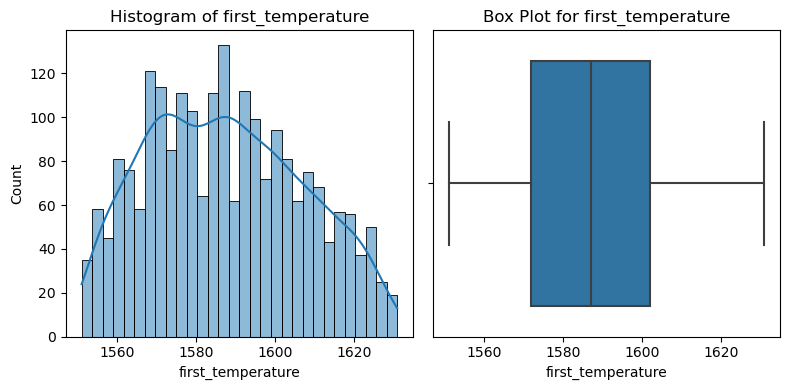

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


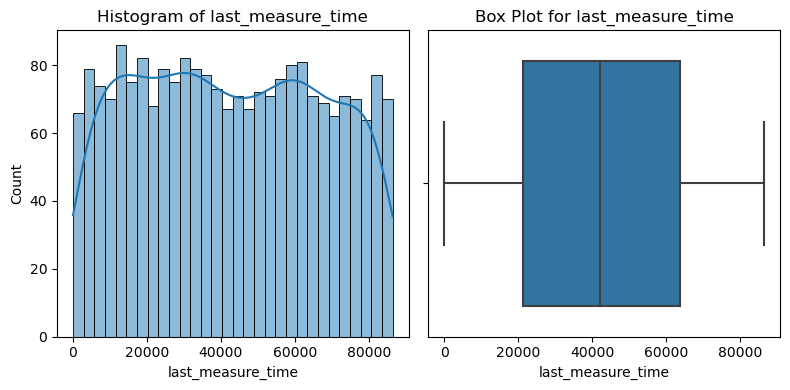

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


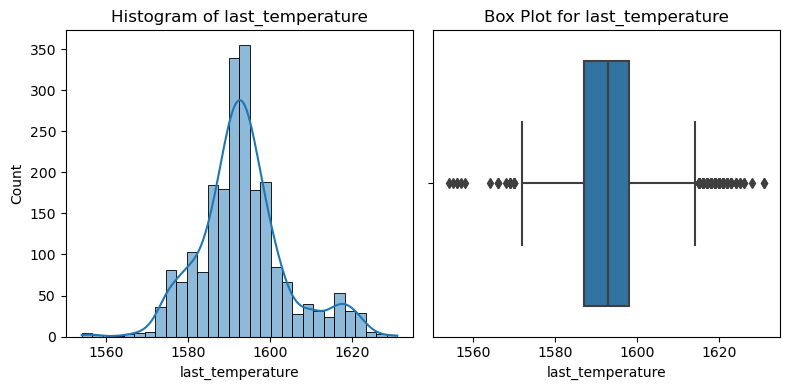

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


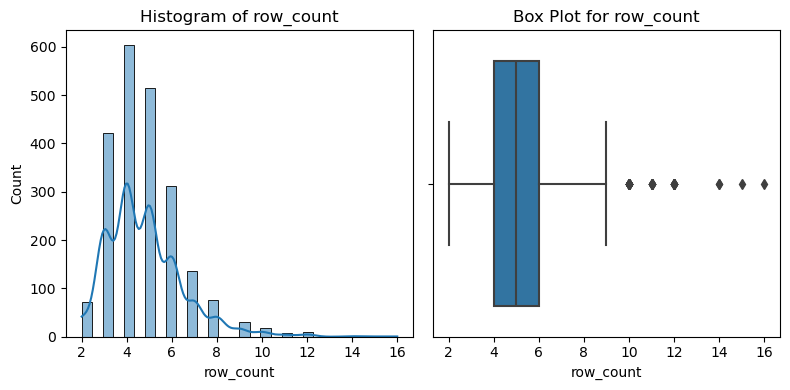

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


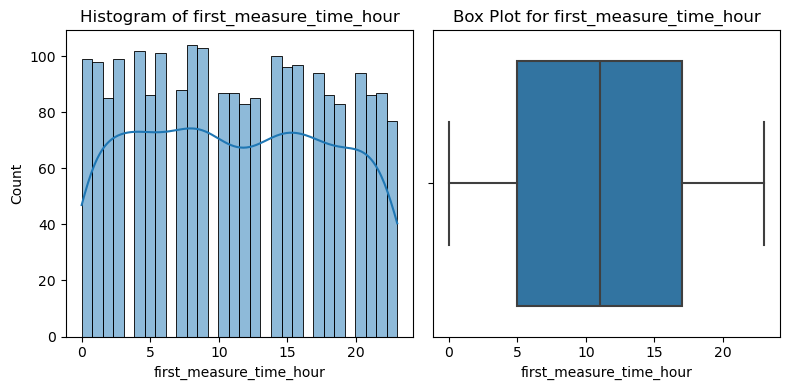

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


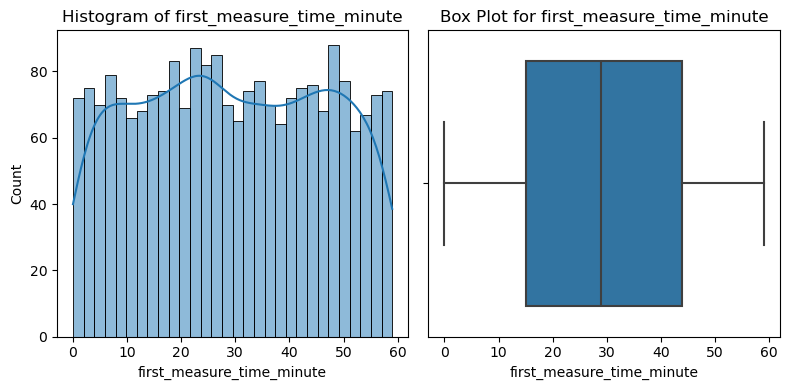

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


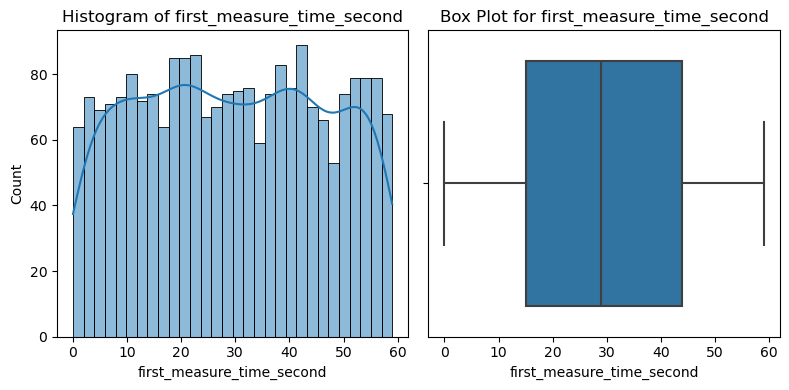

In [130]:
for col in main_data.columns:
    create_stat_plots(main_data, col)

Как видно, большая часть числовых признаков имеет нормальное распределение или равномерное распредление 

Добавлю пару новых признаков:

Час начала обогрева:

In [134]:
main_data['StartHour'] = data_arc['BeginHeat'].apply(
    lambda x: x.hour if pd.notnull(x) else None
)

Проверю корреляцию

In [136]:
numeric_data = main_data.select_dtypes(include=[float, int])
correlation_matrix = numeric_data .corr()

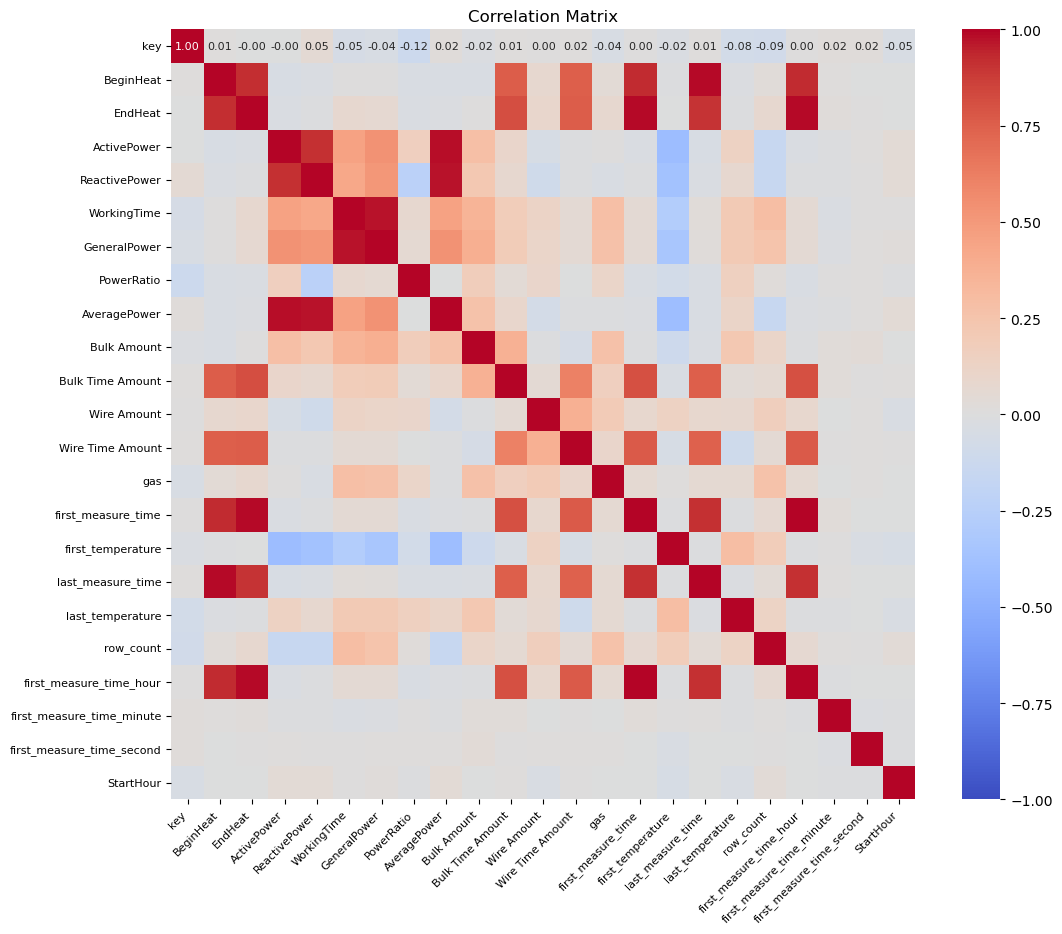

In [137]:
plt.figure(figsize=(12,10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, annot_kws={"size": 8})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=8)
plt.title('Correlation Matrix', fontsize=12)
plt.show()

Наблюдается корреляция между некоторыми признаками

In [139]:
display_data(main_data)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,WorkingTime,GeneralPower,PowerRatio,AveragePower,Bulk Array,...,gas,first_measure_time,first_temperature,last_measure_time,last_temperature,row_count,first_measure_time_hour,first_measure_time_minute,first_measure_time_second,StartHour
0,2,41654,42798,0.763150,0.499528,811,5.050710,1.551834,0.631339,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",...,12.555561,41847,1581.0,43152,1602.0,6,11,37,27,11
1,4,45577,46670,0.802313,0.515074,741,5.269548,1.563487,0.658693,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",...,18.841219,46377,1601.0,46765,1625.0,3,12,52,57,11
2,5,47473,48835,0.575169,0.401622,454,2.930375,1.457997,0.488396,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",...,5.413692,48199,1576.0,48961,1602.0,2,13,23,19,11
3,6,49611,50964,0.767345,0.484151,554,3.754489,1.556920,0.625748,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",...,11.273392,50671,1581.0,51149,1596.0,4,14,4,31,11
4,7,51406,52875,0.636844,0.390324,673,4.108670,1.628748,0.513584,"Bulk 4, Bulk 12, Bulk 14, Bulk 15",...,9.836267,51583,1586.0,52957,1599.0,5,14,19,43,11


<class 'pandas.core.frame.DataFrame'>
Index: 2207 entries, 0 to 2219
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   key                        2207 non-null   int64  
 1   BeginHeat                  2207 non-null   int64  
 2   EndHeat                    2207 non-null   int64  
 3   ActivePower                2207 non-null   float64
 4   ReactivePower              2207 non-null   float64
 5   WorkingTime                2207 non-null   int64  
 6   GeneralPower               2207 non-null   float64
 7   PowerRatio                 2207 non-null   float64
 8   AveragePower               2207 non-null   float64
 9   Bulk Array                 2207 non-null   object 
 10  Bulk Amount                2207 non-null   float64
 11  Bulk Time Amount           2207 non-null   float64
 12  Wire Array                 2207 non-null   object 
 13  Wire Amount                2207 non-null   float64
 1

None

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,WorkingTime,GeneralPower,PowerRatio,AveragePower,Bulk Amount,...,gas,first_measure_time,first_temperature,last_measure_time,last_temperature,row_count,first_measure_time_hour,first_measure_time_minute,first_measure_time_second,StartHour
count,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,...,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000
mean,1252.496149,40777.214318,43857.731309,0.614068,0.455537,691.269597,4.673244,1.364367,0.534803,600.478478,...,10.483591,42242.989579,1587.456729,42619.595378,1593.267331,4.783870,11.236067,29.392841,29.577707,11.591754
std,712.085938,24724.192859,24804.006438,0.160248,0.118953,264.171392,1.869495,0.130268,0.136588,279.524681,...,4.709280,24770.185147,19.658388,24777.087350,10.719921,1.712297,6.878100,17.202680,17.179607,7.016338
min,2.000000,2.000000,733.000000,0.186226,0.130062,57.000000,0.361557,0.687735,0.158950,19.000000,...,0.008399,108.000000,1551.000000,54.000000,1554.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,635.500000,19217.000000,22310.500000,0.498285,0.370669,508.000000,3.338717,1.297019,0.437442,433.000000,...,7.135103,20817.500000,1572.000000,21161.000000,1587.000000,4.000000,5.000000,15.000000,15.000000,6.000000
50%,1255.000000,40218.000000,43482.000000,0.601529,0.445959,680.000000,4.579020,1.375994,0.524618,604.000000,...,9.884287,41656.000000,1587.000000,42069.000000,1593.000000,5.000000,11.000000,29.000000,29.000000,12.000000
75%,1864.500000,61515.000000,64735.500000,0.721545,0.535115,857.500000,5.844844,1.443274,0.626691,783.500000,...,13.513411,63400.500000,1602.000000,63601.500000,1598.000000,6.000000,17.000000,44.000000,44.000000,18.000000
max,2499.000000,85516.000000,86398.000000,1.261694,0.986905,2196.000000,15.373229,1.785275,1.114584,1569.000000,...,23.811279,86379.000000,1631.000000,86394.000000,1631.000000,16.000000,23.000000,59.000000,59.000000,23.000000


In [156]:
X = main_data.drop(['last_temperature', 'key'], axis=1)
y = main_data['last_temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

In [158]:
display(X_train.shape)
display(X_test.shape)
display(X_val.shape)

(1323, 23)

(442, 23)

(442, 23)

Разделение выборки на признаки и таргет, а также разделение последних на тренировочную, валидационную и тестовую выборки

**2. Обучение модели**

In [162]:
categorical_features = []
numeric_features = []

for column in X.columns:
    if pd.api.types.is_numeric_dtype(X[column]):
        numeric_features.append(column)
    else:
        categorical_features.append(column)

In [164]:
numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

Определю числовые и категориальные признаки

In [166]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Определю колумн трансформер

In [218]:
columns = ['BestModel', 'BestParameters', 'MAE', 'RMSE', 'R2']
metrics_df = pd.DataFrame(columns=columns)
test_metrics_df = pd.DataFrame(columns=columns)

Таблицы для вывода метрик моделей

In [170]:
def create_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

Функция создания пайплайна

In [172]:
def metrics_report(pipeline, X_train, y_train, X_val, y_val):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    return mae, rmse, r2

Функция для вычисления метрик

In [174]:
def train_dummy_model(X_train, y_train, X_val, y_val):
    model = DummyClassifier(strategy='most_frequent')
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    metrics = {
        'BestModel': 'dummy_model',
        'BestParameters': 'N/A', 
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }
    
    return metrics

Функция обучения константной модели

In [176]:
def objective_logistic_regression(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    model = LogisticRegression(C=C, solver='liblinear', random_state=RANDOM_STATE)
    pipeline = create_pipeline(model)
    mae, rmse, r2 = metrics_report(pipeline, X_train, y_train, X_val, y_val)
    
    trial.set_user_attr('model_type', 'logistic_regression')
    trial.set_user_attr('mae', mae)
    trial.set_user_attr('rmse', rmse)
    trial.set_user_attr('r2', r2)
    
    return mae

Функция обучения логистической регрессии с подбором гипперпараметров 

In [178]:
def objective_regressor_tree(trial):
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'poisson'])
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', [None, 'auto', 'sqrt', 'log2'] + list(range(1, X_train.shape[1] + 1)))
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 5, 50, step=5) if trial.suggest_categorical('use_max_leaf_nodes', [True, False]) else None
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 0.1, step=0.01)
    
    model = DecisionTreeRegressor(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        splitter=splitter,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        random_state=RANDOM_STATE
    )
    
    pipeline = create_pipeline(model)
    mae, rmse, r2 = metrics_report(pipeline, X_train, y_train, X_val, y_val)
    
    trial.set_user_attr('model_type', 'decision_tree')
    trial.set_user_attr('mae', mae)
    trial.set_user_attr('rmse', rmse)
    trial.set_user_attr('r2', r2)
    
    return mae

Функция обучения "деревянной" модели с подбором гипперпараметров 

In [180]:
def objective_catboost(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    depth = trial.suggest_int('depth', 3, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1, 10)
    iterations = trial.suggest_int('iterations', 100, 1000)
    
    model = CatBoostRegressor(
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        iterations=iterations,
        task_type='GPU',
        random_state=RANDOM_STATE,
        verbose=0
    )
    
    pipeline = create_pipeline(model)
    try:
        mae, rmse, r2 = metrics_report(pipeline, X_train, y_train, X_val, y_val)
        trial.set_user_attr('model_type', 'catboost')
        trial.set_user_attr('mae', mae)
        trial.set_user_attr('rmse', rmse)
        trial.set_user_attr('r2', r2)
        return mae
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('inf')

Функция обучения градиентного бустинга (катбуста) с подбором гипперпараметров 

In [182]:
def objective_mlp_regression(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(64,), (128,), (64, 64), (128, 64)])
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
    
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        random_state=RANDOM_STATE,
        max_iter=2000
    )
    
    pipeline = create_pipeline(model)
    
    try:
        mae, rmse, r2 = metrics_report(pipeline, X_train, y_train, X_val, y_val)
        trial.set_user_attr('model_type', 'mlp_regression')
        trial.set_user_attr('mae', mae)
        trial.set_user_attr('rmse', rmse)
        trial.set_user_attr('r2', r2)
        return mae
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('inf')

Функция обучения MLP нейросети с подбором гипперпараметров 

In [184]:
def add_best_metrics_to_df(df, model_type, best_params, mae, rmse, r2):
    new_row = pd.DataFrame([{
        'BestModel': model_type,
        'BestParameters': best_params,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }])
    
    df = pd.concat([df, new_row], ignore_index=True)
    return df

Функция добавления метрик лучшей модели по результатам работы оптюна

In [215]:
def evaluate_best_model_on_test(best_model, X_test, y_val):
    y_pred = best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    return mae, rmse, r2

Функция тестирования лучшей модели

In [188]:
dummy_metrics = train_dummy_model(X_train, y_train, X_val, y_test)

dummy_metrics_df = pd.DataFrame([dummy_metrics])
metrics_df = pd.concat([metrics_df, dummy_metrics_df], ignore_index=True)

C:\Users\miks9\AppData\Local\Temp\ipykernel_20448\4244580424.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, dummy_metrics_df], ignore_index=True)


Обучение константной модели

In [190]:
study_logistic = optuna.create_study(direction='minimize')
study_logistic.optimize(objective_logistic_regression, n_trials=N_TRIALS)

best_logistic_trial = study_logistic.best_trial

metrics_df = add_best_metrics_to_df(
    metrics_df,
    best_logistic_trial.user_attrs['model_type'],
    best_logistic_trial.params,
    best_logistic_trial.user_attrs['mae'],
    best_logistic_trial.user_attrs['rmse'],
    best_logistic_trial.user_attrs['r2']
)

[I 2024-07-24 21:30:26,669] A new study created in memory with name: no-name-c623b0e9-78d9-4940-8d13-5ee16d0628ab
[I 2024-07-24 21:30:27,314] Trial 0 finished with value: 8.843891402714933 and parameters: {'C': 78.94939853708483}. Best is trial 0 with value: 8.843891402714933.
[I 2024-07-24 21:30:27,873] Trial 1 finished with value: 8.649321266968325 and parameters: {'C': 60.3303380172935}. Best is trial 1 with value: 8.649321266968325.
[I 2024-07-24 21:30:28,785] Trial 2 finished with value: 8.950226244343892 and parameters: {'C': 636.4416235888012}. Best is trial 1 with value: 8.649321266968325.
[I 2024-07-24 21:30:29,560] Trial 3 finished with value: 8.868778280542987 and parameters: {'C': 289.1613098872999}. Best is trial 1 with value: 8.649321266968325.
[I 2024-07-24 21:30:29,816] Trial 4 finished with value: 8.14027149321267 and parameters: {'C': 1.2763677438579895}. Best is trial 4 with value: 8.14027149321267.
[I 2024-07-24 21:30:30,067] Trial 5 finished with value: 8.165158371

Обучение логистической регрессии 

In [191]:
study_decision_tree = optuna.create_study(direction='minimize')
study_decision_tree.optimize(objective_regressor_tree, n_trials=N_TRIALS)

best_decision_tree_trial = study_decision_tree.best_trial

metrics_df = add_best_metrics_to_df(
    metrics_df,
    best_decision_tree_trial.user_attrs['model_type'],
    best_decision_tree_trial.params,
    best_decision_tree_trial.user_attrs['mae'],
    best_decision_tree_trial.user_attrs['rmse'],
    best_decision_tree_trial.user_attrs['r2']
)

[I 2024-07-24 21:31:10,180] A new study created in memory with name: no-name-7f93fb52-dde8-4319-a027-35f5cfec41ec
[I 2024-07-24 21:31:10,212] Trial 0 finished with value: 7.638009049773756 and parameters: {'criterion': 'absolute_error', 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'splitter': 'random', 'use_max_leaf_nodes': True, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.06}. Best is trial 0 with value: 7.638009049773756.
[I 2024-07-24 21:31:10,244] Trial 1 finished with value: 7.638009049773756 and parameters: {'criterion': 'absolute_error', 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 4, 'splitter': 'random', 'use_max_leaf_nodes': False, 'min_impurity_decrease': 0.1}. Best is trial 0 with value: 7.638009049773756.
[I 2024-07-24 21:31:10,307] Trial 2 finished with value: 7.542986425339366 and parameters: {'criterion': 'absolute_error', 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2, 'ma

Обучение "деревянной" модели

In [192]:
study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=N_TRIALS)

best_catboost_trial = study_catboost.best_trial

metrics_df = add_best_metrics_to_df(
    metrics_df,
    best_catboost_trial.user_attrs['model_type'],
    best_catboost_trial.params,
    best_catboost_trial.user_attrs['mae'],
    best_catboost_trial.user_attrs['rmse'],
    best_catboost_trial.user_attrs['r2']
)

[I 2024-07-24 21:31:27,756] A new study created in memory with name: no-name-622b688b-9912-4be1-a092-9ebf5b6b9db3
[I 2024-07-24 21:31:32,367] Trial 0 finished with value: 6.623744434086717 and parameters: {'learning_rate': 0.23776803993524293, 'depth': 9, 'l2_leaf_reg': 2.4049081520870046, 'iterations': 459}. Best is trial 0 with value: 6.623744434086717.
[I 2024-07-24 21:31:34,337] Trial 1 finished with value: 6.428232281096303 and parameters: {'learning_rate': 0.15199986878185737, 'depth': 5, 'l2_leaf_reg': 3.3110457812504976, 'iterations': 418}. Best is trial 1 with value: 6.428232281096303.
[I 2024-07-24 21:31:45,106] Trial 2 finished with value: 6.517323596023017 and parameters: {'learning_rate': 0.0567188445434871, 'depth': 7, 'l2_leaf_reg': 6.6360737070046465, 'iterations': 644}. Best is trial 1 with value: 6.428232281096303.
[I 2024-07-24 21:32:13,564] Trial 3 finished with value: 6.452123499765458 and parameters: {'learning_rate': 0.043850075895987016, 'depth': 10, 'l2_leaf_re

Обучение градиентной модели

In [193]:
study_mlp = optuna.create_study(direction='minimize')
study_mlp.optimize(objective_mlp_regression, n_trials=N_TRIALS)

best_mlp_trial = study_mlp.best_trial

metrics_df = add_best_metrics_to_df(
    metrics_df,
    best_mlp_trial.user_attrs['model_type'],
    best_mlp_trial.params,
    best_mlp_trial.user_attrs['mae'],
    best_mlp_trial.user_attrs['rmse'],
    best_mlp_trial.user_attrs['r2']
)

[I 2024-07-24 21:46:15,027] A new study created in memory with name: no-name-3f815d2a-e3b3-4935-b5e4-dc750555d0ed
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128,) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 64) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be

An error occurred: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.


D:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2024-07-24 21:47:19,871] Trial 2 finished with value: 7.746606334841629 and parameters: {'hidden_layer_sizes': (64,), 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0011769593766270652, 'learning_rate': 'adaptive'}. Best is trial 2 with value: 7.746606334841629.
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128,) which is of type tuple.
  warnings.warn(message)
D:

An error occurred: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.


D:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2024-07-24 21:48:20,519] Trial 6 finished with value: 12.20268386873642 and parameters: {'hidden_layer_sizes': (64, 64), 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.0007829878582324888, 'learning_rate': 'constant'}. Best is trial 2 with value: 7.746606334841629.
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarnin

An error occurred: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.


D:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2024-07-24 22:08:39,100] Trial 108 finished with value: 6.493679610974347 and parameters: {'hidden_layer_sizes': (64, 64), 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 0.008211367258539772, 'learning_rate': 'adaptive'}. Best is trial 90 with value: 6.478224740596604.
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarn

An error occurred: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.


D:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2024-07-24 22:12:29,986] Trial 129 finished with value: 12.384348373134843 and parameters: {'hidden_layer_sizes': (64, 64), 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.0004568420012879078, 'learning_rate': 'constant'}. Best is trial 90 with value: 6.478224740596604.
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWa

An error occurred: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.


[I 2024-07-24 22:17:24,674] Trial 157 finished with value: 6.547948401564606 and parameters: {'hidden_layer_sizes': (64, 64), 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 0.0022794274831829694, 'learning_rate': 'constant'}. Best is trial 90 with value: 6.478224740596604.
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128,) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 64) wh

An error occurred: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.


[I 2024-07-24 22:22:51,777] Trial 188 finished with value: 6.479362499673923 and parameters: {'hidden_layer_sizes': (64, 64), 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 0.0007873144063716487, 'learning_rate': 'adaptive'}. Best is trial 90 with value: 6.478224740596604.
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128,) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64, 64) wh

An error occurred: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.


D:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2024-07-24 22:30:00,744] Trial 228 finished with value: 6.570111618914727 and parameters: {'hidden_layer_sizes': (64, 64), 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 0.000364633272560081, 'learning_rate': 'adaptive'}. Best is trial 90 with value: 6.478224740596604.
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (64,) which is of type tuple.
  warnings.warn(message)
D:\Anaconda\Lib\site-packages\optuna\distributions.py:524: UserWarn

Обучение нейросети 

In [194]:
metrics_df

,BestModel,BestParameters,MAE,RMSE,R2
0,dummy_model,N/A,7.690045,10.493372,-0.035178
1,logistic_regression,{'C': 0.009391626107818234},7.794118,11.033782,-0.022625
2,decision_tree,"{'criterion': 'squared_error', 'max_depth': 9,...",7.067964,9.844484,0.185945
3,catboost,"{'learning_rate': 0.13309731269460973, 'depth'...",6.199265,8.490184,0.394517
4,mlp_regression,"{'hidden_layer_sizes': (64, 64), 'activation':...",6.478225,8.779440,0.352557


Гиппермараметры и метрики лучших моделей в результате обучения. Как видно, лучшие результаты показала модель градиентного спуска и нейронная сеть

**4. Тестирование моделей**

In [220]:
best_params_logistic = best_logistic_trial.params
best_logistic_model = LogisticRegression(
    C=best_params_logistic['C'],
    solver='liblinear',
    random_state=RANDOM_STATE
)

best_logistic_pipeline = create_pipeline(best_logistic_model)
best_logistic_pipeline.fit(X_train, y_train)

mae_test, rmse_test, r2_test = evaluate_best_model_on_test(best_logistic_pipeline, X_test, y_test)

test_metrics_df = add_best_metrics_to_df(
    test_metrics_df,
    'logistic_regression',
    best_params_logistic,
    mae_test,
    rmse_test,
    r2_test
)

C:\Users\miks9\AppData\Local\Temp\ipykernel_20448\346099846.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


Тестирование линейной регрессии

In [223]:
best_params_decision_tree = best_decision_tree_trial.params

best_decision_tree_model = DecisionTreeRegressor(
    criterion=best_params_decision_tree.get('criterion', 'squared_error'),
    max_depth=best_params_decision_tree.get('max_depth', None),
    min_samples_split=best_params_decision_tree.get('min_samples_split', 2),
    min_samples_leaf=best_params_decision_tree.get('min_samples_leaf', 1),
    max_features=best_params_decision_tree.get('max_features', None),
    splitter=best_params_decision_tree.get('splitter', 'best'),
    max_leaf_nodes=best_params_decision_tree.get('max_leaf_nodes', None),
    min_impurity_decrease=best_params_decision_tree.get('min_impurity_decrease', 0.0),
    random_state=RANDOM_STATE
)

best_decision_tree_pipeline = create_pipeline(best_decision_tree_model)
best_decision_tree_pipeline.fit(X_train, y_train)

mae_test, rmse_test, r2_test = evaluate_best_model_on_test(best_decision_tree_pipeline, X_test, y_test)

test_metrics_df = add_best_metrics_to_df(
    test_metrics_df,
    'decision_tree',
    best_params_decision_tree,
    mae_test,
    rmse_test,
    r2_test
)

Тестирование деревянной модели

In [226]:
best_params_catboost = best_catboost_trial.params

best_catboost_model = CatBoostRegressor(
    learning_rate=best_params_catboost.get('learning_rate', 0.1),
    depth=best_params_catboost.get('depth', 6),
    l2_leaf_reg=best_params_catboost.get('l2_leaf_reg', 3.0),
    iterations=best_params_catboost.get('iterations', 500),
    task_type='GPU',
    random_state=RANDOM_STATE,
    verbose=0
)

best_catboost_pipeline = create_pipeline(best_catboost_model)
best_catboost_pipeline.fit(X_train, y_train)

mae_test, rmse_test, r2_test = evaluate_best_model_on_test(best_catboost_pipeline, X_test, y_test)

test_metrics_df = add_best_metrics_to_df(
    test_metrics_df,
    'catboost',
    best_params_catboost,
    mae_test,
    rmse_test,
    r2_test
)

Тестирование градиентной модели

In [229]:
best_params_mlp = best_mlp_trial.params

best_mlp_model = MLPRegressor(
    hidden_layer_sizes=best_params_mlp.get('hidden_layer_sizes', (100,)),
    activation=best_params_mlp.get('activation', 'relu'),
    solver=best_params_mlp.get('solver', 'adam'),
    alpha=best_params_mlp.get('alpha', 0.0001),
    learning_rate=best_params_mlp.get('learning_rate', 'constant'),
    max_iter=best_params_mlp.get('max_iter', 2000),
    random_state=RANDOM_STATE
)

best_mlp_pipeline = create_pipeline(best_mlp_model)
best_mlp_pipeline.fit(X_train, y_train)

mae_test, rmse_test, r2_test = evaluate_best_model_on_test(best_mlp_pipeline, X_test, y_test)

test_metrics_df = add_best_metrics_to_df(
    test_metrics_df,
    'mlp',
    best_params_mlp,
    mae_test,
    rmse_test,
    r2_test
)

D:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Тестирование нейронной сети

In [231]:
test_metrics_df

,BestModel,BestParameters,MAE,RMSE,R2
0,logistic_regression,{'C': 0.009391626107818234},7.601810,10.389039,-0.014695
1,decision_tree,"{'criterion': 'squared_error', 'max_depth': 9,...",7.389246,9.831218,0.091344
2,catboost,"{'learning_rate': 0.13309731269460973, 'depth'...",6.740722,8.897336,0.255774
3,mlp,"{'hidden_layer_sizes': (64, 64), 'activation':...",7.278540,9.923003,0.074298


В результате подбора гипперпараметров получилось создать модель, отвечающую требованиям заказчика по метрике МАЕ(<6,8) - модель градиентного спуска

Метрика R2 не самая высокая. Возможно увеличение выборки могло бы обучить модель лучше и помочь с предсказанием значений

Значение МАЕ catboost модели лучше констной на 1. Катбуст модель справляется с предсказанием лучше

NameError: name 'pipeline' is not defined

In [272]:
best_catboost_pipeline = create_pipeline(best_catboost_model)
best_catboost_pipeline.fit(X_train, y_train)

preprocessor_fitted = best_catboost_pipeline.named_steps['preprocessor']

categorical_transformer_fitted = preprocessor_fitted.named_transformers_['cat']
categorical_feature_names = categorical_transformer_fitted.get_feature_names_out()

numeric_feature_names = numeric_features

all_feature_names = numeric_feature_names + list(categorical_feature_names)

importances = best_catboost_pipeline.named_steps['regressor'].get_feature_importance()

importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [274]:
importance_df

,Feature,Importance
14,first_temperature,16.453070
8,Bulk Amount,8.071743
5,GeneralPower,8.038648
6,PowerRatio,7.232582
12,gas,5.464130
...,...,...
100,"Bulk Array_Bulk 4, Bulk 12, Bulk 14",0.000000
104,"Bulk Array_Bulk 4, Bulk 5, Bulk 12, Bulk 14, B...",0.000000
105,"Bulk Array_Bulk 4, Bulk 5, Bulk 14",0.000000
108,"Bulk Array_Bulk 5, Bulk 12, Bulk 14",0.000000


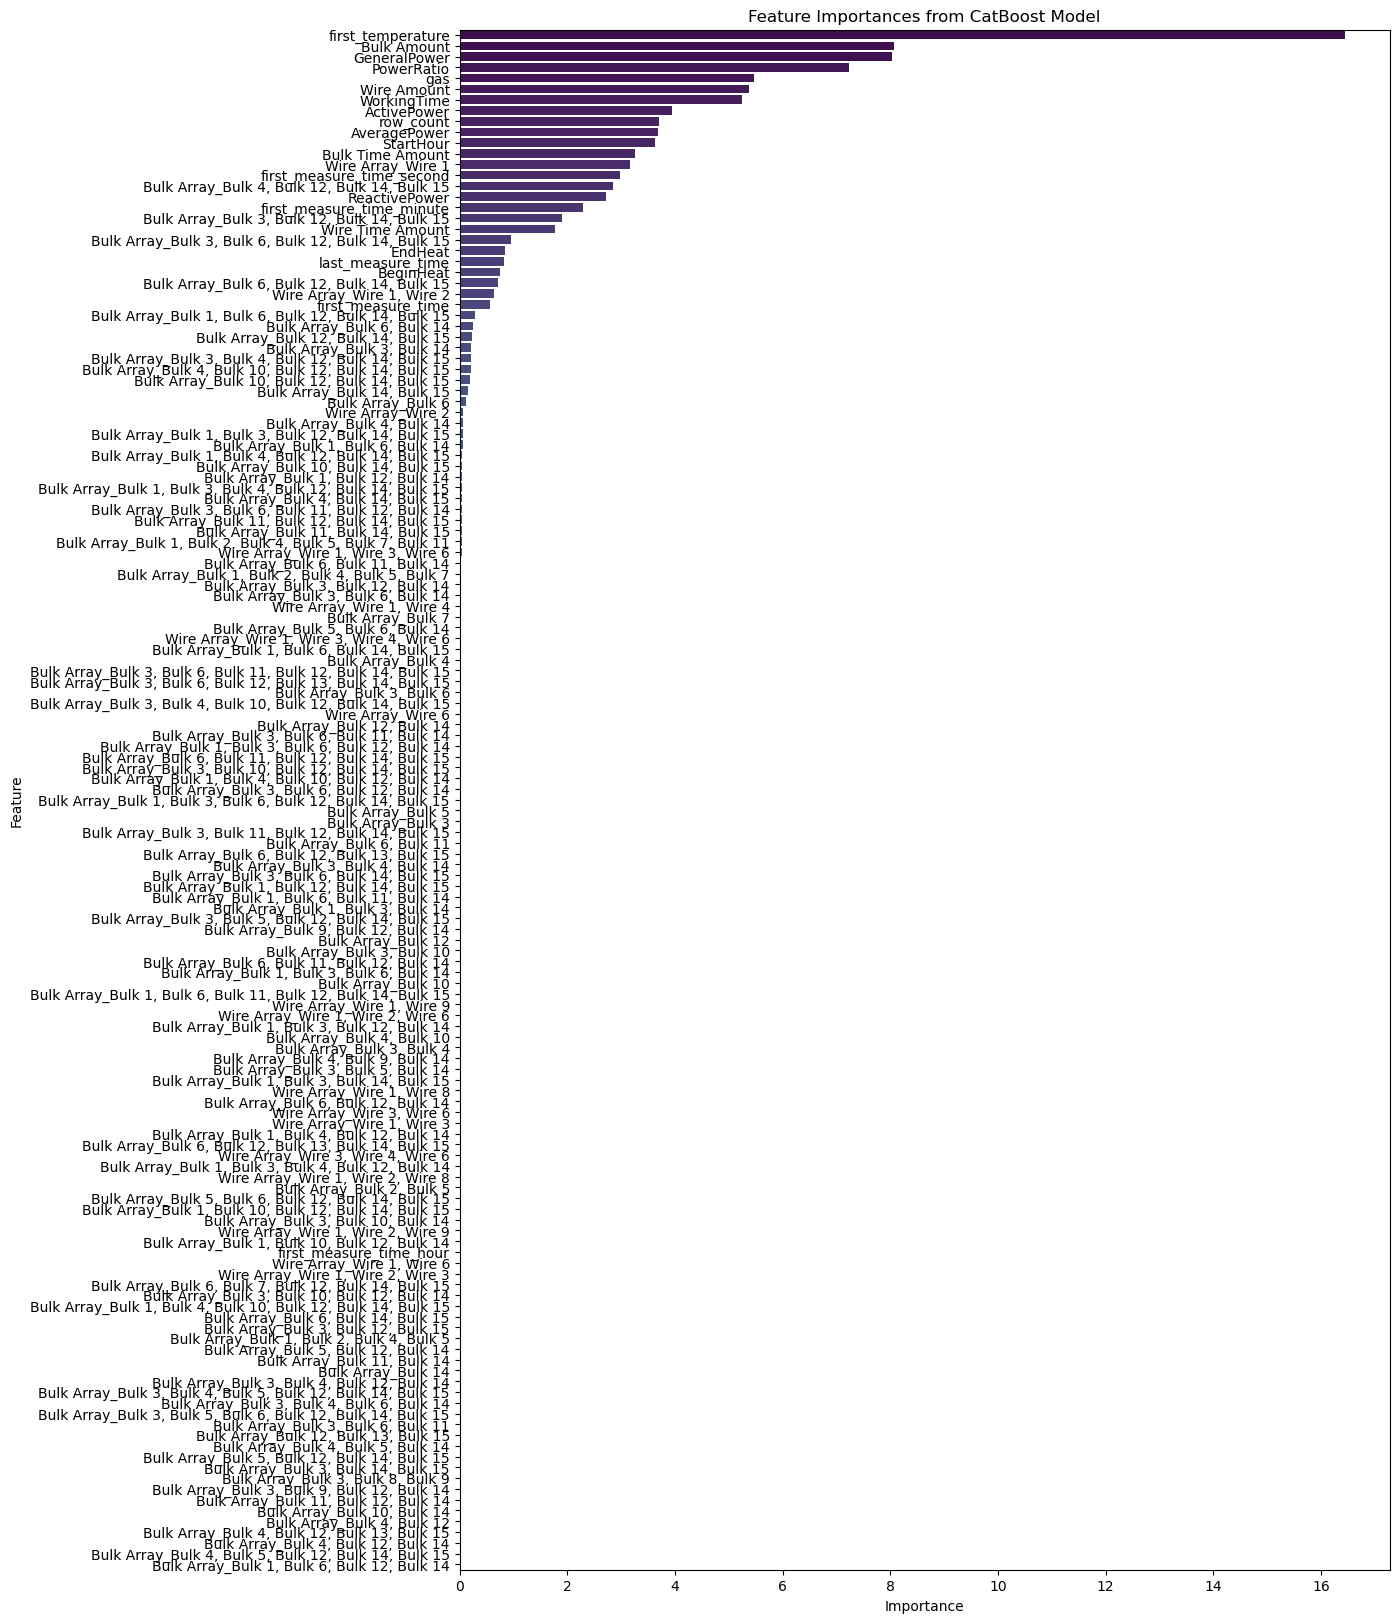

In [282]:
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 20))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances from CatBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Как видно из графика, наиболее важными признаками для модели являлись численные признаки, например статовой температуры, общего количества примесей и общей подаваемой мощности

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


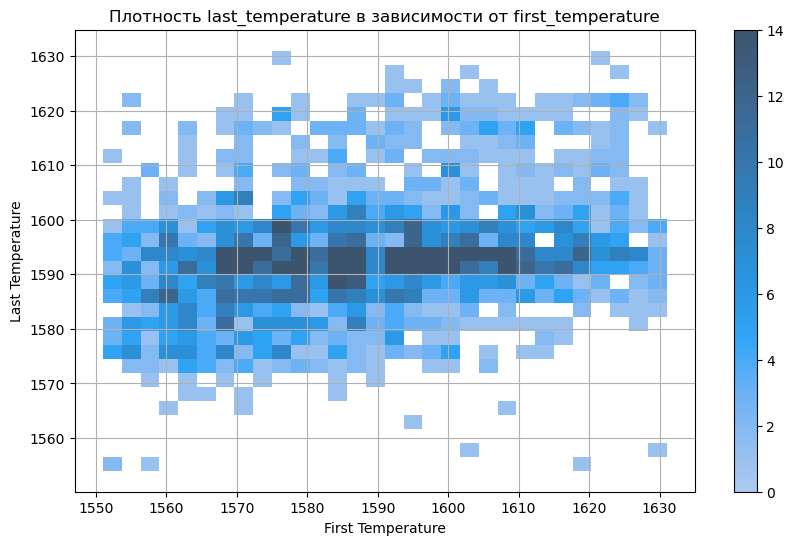

In [288]:
plt.figure(figsize=(10, 6))
sns.histplot(x='first_temperature', y='last_temperature', data=main_data, bins=30, pmax=0.8, cbar=True)
plt.title('Плотность last_temperature в зависимости от first_temperature')
plt.xlabel('First Temperature')
plt.ylabel('Last Temperature')
plt.grid(True)
plt.show()

Как видно, большая часть точке расположена для температу 1550-1630 для начальной температуры, и 1570-1620 для конечной.
Максимальная плотность конечной температуры в районе 1595 градусов цельсия

**5. Выводы**

Окончательная модель градиентного бустинга в итоге дала значение МАЕ 6,74. Значение R2 метрики 0,25. 

Дальнейшее улучшение метрик модели возможно посредством увеличения начальной выборки, а также более детальной предобработкой данных.